<a href="https://colab.research.google.com/github/rodgerrashan/FlowGuard/blob/main/agentic-ids/models/training/AE_NEXT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Zero Day Attack detection

Library installation

In [1]:
!pip install -q tensorflow scikit-learn pandas numpy matplotlib seaborn wandb

Login to wandb and save your API key as a COLAB SECRET. https://wandb.ai/


In [2]:
import os
import wandb
from google.colab import userdata

wandb.login(userdata.get("WANDB_API_KEY"))

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: e20168 (e20168-university-of-peradeniya) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

Setup libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.ensemble import IsolationForest

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import EarlyStopping


Ensure that your experiments are reproducible.

In [4]:
def set_all_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

    # Optional: For absolute precision with GPU operations
    # Note: This can slightly slow down training
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_all_seeds(42)

Connecting to T4 GPU

In [5]:
# Check if a GPU is available
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  print("GPU device not found. Check your runtime settings.")
else:
  print(f"Found GPU at: {device_name}")

# Alternative method to list physical devices
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Found GPU at: /device:GPU:0
Num GPUs Available:  1


Mounting G Drive

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load CIC-IDS 2017 CSV Files

In [7]:
benign_filepath = "/content/drive/MyDrive/FYP/Data/UNSW NB15/UNSW_NB15_training-set.csv"

df = pd.read_csv(benign_filepath)
df.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [8]:
df.shape

(175341, 45)

In [9]:
# df.info()

#### PreProcessing

In [10]:
def clean_data(df):
  df = df.replace([np.inf, -np.inf], np.nan)
  df = df.dropna()
  return df

cleaned_df = clean_data(df)

# Strip white spapces in column names
cleaned_df.columns = cleaned_df.columns.str.strip()

cleaned_df.shape

(175341, 45)

Here label processign happens:

* BENIGN -> 0
* Attack -> 1

In [11]:
# cleaned_df.info()

In [12]:
# Drop unnecessary columns
df = cleaned_df.drop(['id', 'attack_cat'], axis=1)

# seperate labels
y = df['label']
X = df.drop(columns = ['label'])

According to the d.info, we have here several categorical column features such as 'proto', 'service', 'state'. So we have to perform one-hot encoding.

In [13]:
categorical_cols = ['proto', 'service', 'state']
numeric_cols = X.columns.difference(categorical_cols)

In [14]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(
    drop='first',
    handle_unknown='ignore',
    sparse_output=False
)

X_cat = encoder.fit_transform(X[categorical_cols])
X_cat = pd.DataFrame(X_cat, columns=encoder.get_feature_names_out(categorical_cols))

X_num = X[numeric_cols]

### Feature Engineering

We have to get correlation matrix, just to identify what are the unwanted columns those are not directly go with attack.

/tmp/ipython-input-876085492.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


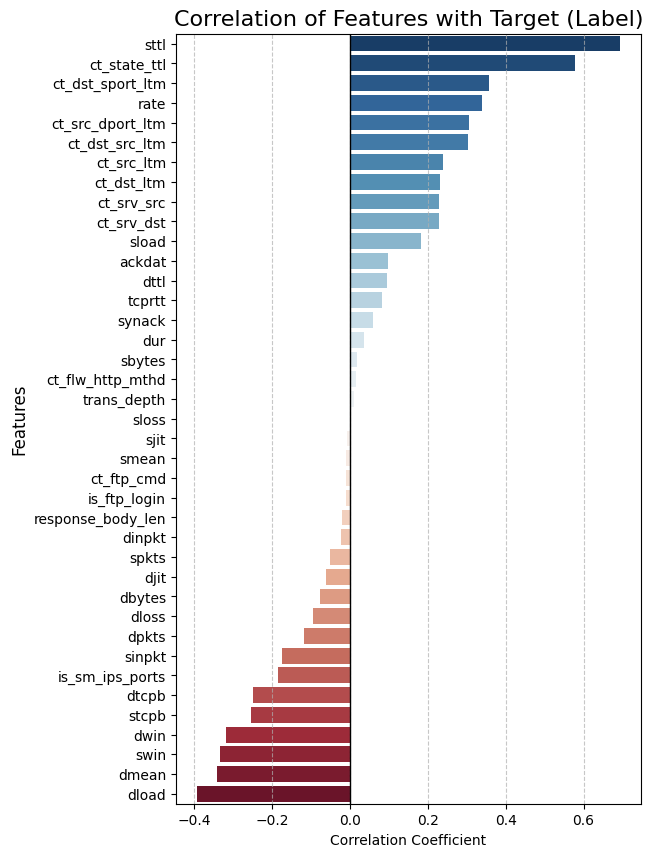

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Full data without cat data
full_data = X_num.copy()
full_data['label'] = y

target_corr = full_data.corr()['label'].drop('label').sort_values(ascending=False)

plt.figure(figsize=(6, 10))
sns.barplot(
    x=target_corr.values,
    y=target_corr.index,
    palette='RdBu_r'
)

plt.axvline(x=0, color='black', linestyle='-', linewidth=1)
plt.title("Correlation of Features with Target (Label)", fontsize=16)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Features", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()

In [16]:
correlations = full_data.corr()['label'].drop('label').abs()

# threshold (e.g., 0.1 means 10% correlation)
threshold = 0.20

# Need Features
relevant_features = correlations[correlations > threshold].index

print(set(relevant_features))

# filtered DataFrame
X_num_filtered = X_num[relevant_features]

print(f"Original number of columns: {full_data.shape[1]}")
print(f"Columns kept after threshold: {len(relevant_features)}")
print(f"Dropped columns: {set(full_data.columns) - set(relevant_features)}")

{'swin', 'sttl', 'ct_state_ttl', 'ct_srv_dst', 'dload', 'dtcpb', 'ct_src_ltm', 'dmean', 'ct_dst_ltm', 'ct_srv_src', 'ct_dst_src_ltm', 'rate', 'stcpb', 'ct_src_dport_ltm', 'dwin', 'ct_dst_sport_ltm'}
Original number of columns: 40
Columns kept after threshold: 16
Dropped columns: {'djit', 'dttl', 'is_ftp_login', 'sbytes', 'sjit', 'spkts', 'response_body_len', 'dpkts', 'synack', 'dbytes', 'sload', 'trans_depth', 'sloss', 'dinpkt', 'is_sm_ips_ports', 'dloss', 'label', 'ct_ftp_cmd', 'smean', 'dur', 'ackdat', 'sinpkt', 'ct_flw_http_mthd', 'tcprtt'}


In [17]:
X_processed = pd.concat([X_num_filtered, X_cat], axis=1)
X_processed.shape

(175341, 168)

We proposed to use Autoencoders for here. So AE should be trained only on normal traffic.

In [18]:
X_train = X_processed[y == 0]

X_test = X_processed # all data to test
y_test = y

Next, we have to do feature scaling.

In [19]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
# scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


#### Build AutoEncoder Model

In [45]:
import wandb


run = wandb.init(
    project="AE_training_FYP_Dawn",
    name="Alexandra C764",
    notes="Batch size reduced to 64",

    config={
        "batch_size": 64,
        "epochs": 50,
        "model": "AutoEncoder",
        "dataset": "UNSW-NB15",
        "patience": 5,
        "optimizer": "Adam",
        "threshold_percentile": 99,
        "loss":"mae",
        "scaler":"StandardScaler",
        "dropout_rate": 0.2,
        "bottleneck_dim": 32,
        "noise_stddev": 0.1,
        "learning_rate": 1e-3,
    }
)


In [46]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, Dropout, BatchNormalization,
                                     LeakyReLU, GaussianNoise, Add, Concatenate)
from tensorflow.keras.regularizers import l1_l2

# Assume X_train_scaled is your preprocessed training data (only normal samples)
input_dim = X_train_scaled.shape[1]  # e.g., 168

# Hyperparameters
dropout_rate = run.config.dropout_rate
l1_reg = 1e-5
l2_reg = 1e-5
noise_stddev = run.config.noise_stddev

# ------------------- Input with optional noise (Denoising AE) -------------------
input_layer = Input(shape=(input_dim,))
noisy_input = GaussianNoise(stddev=noise_stddev)(input_layer)

# ------------------- Encoder -------------------
# Level 1
enc1 = Dense(256, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(noisy_input)
enc1 = BatchNormalization()(enc1)
enc1 = LeakyReLU(0.1)(enc1)
enc1 = Dropout(dropout_rate)(enc1)

# Level 2
enc2 = Dense(128, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(enc1)
enc2 = BatchNormalization()(enc2)
enc2 = LeakyReLU(0.1)(enc2)
enc2 = Dropout(dropout_rate)(enc2)

# Level 3
enc3 = Dense(64, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(enc2)
enc3 = BatchNormalization()(enc3)
enc3 = LeakyReLU(0.1)(enc3)

# Bottleneck with strong regularization
bottleneck = Dense(32,
                   activation=None,
                   activity_regularizer=l1_l2(l1=1e-4, l2=1e-4))(enc3)
bottleneck = BatchNormalization()(bottleneck)
bottleneck = LeakyReLU(0.1)(bottleneck)

# ------------------- Decoder with Skip Connections -------------------
# Level 3 → 64
dec3 = Dense(64, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(bottleneck)
dec3 = BatchNormalization()(dec3)
dec3 = LeakyReLU(0.1)(dec3)
dec3 = Dropout(dropout_rate)(dec3)
# Skip connection from enc3
dec3 = Add()([dec3, enc3])  # Residual

# Level 2 → 128
dec2 = Dense(128, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(dec3)
dec2 = BatchNormalization()(dec2)
dec2 = LeakyReLU(0.1)(dec2)
dec2 = Dropout(dropout_rate)(dec2)
dec2 = Add()([dec2, enc2])

# Level 1 → 256
dec1 = Dense(256, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(dec2)
dec1 = BatchNormalization()(dec1)
dec1 = LeakyReLU(0.1)(dec1)
dec1 = Dropout(dropout_rate)(dec1)
dec1 = Add()([dec1, enc1])

# Output
output_layer = Dense(input_dim, activation='linear')(dec1)

# ------------------- Model -------------------
autoencoder = Model(inputs=input_layer, outputs=output_layer)

# autoencoder.summary()

#### Model Training

Linking with wandb to visualize the training

In [47]:
import wandb
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score

class WandbAnomalyDetectionCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val_true_recon, y_val_labels=None, threshold_percentile=99):
        super().__init__()
        self.X_val = X_val
        self.y_val_true_recon = y_val_true_recon  # for reconstruction (should be same as X_val)
        self.y_val_labels = y_val_labels          # ground truth anomaly labels (0=normal, 1=anomaly)
        self.threshold_percentile = threshold_percentile
        self.best_threshold = None

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}

        # Get reconstructions on validation set
        recon_val = self.model.predict(self.X_val, verbose=0)
        recon_error_val = np.mean(np.square(self.X_val - recon_val), axis=1)

        # Log reconstruction error statistics
        wandb.log({
            "val/reconstruction_mse_mean": np.mean(recon_error_val),
            "val/reconstruction_mse_std": np.std(recon_error_val),
            "val/reconstruction_mse_median": np.median(recon_error_val),
            "val/reconstruction_mse_95th": np.percentile(recon_error_val, 95),
            "val/reconstruction_mse_99th": np.percentile(recon_error_val, 99),
        }, step=epoch)

        # Compute threshold based on training data (you should precompute this ideally)
        # Here we approximate using current val set assuming it's mostly normal
        threshold = np.percentile(recon_error_val, self.threshold_percentile)
        predictions = (recon_error_val > threshold).astype(int)

        # If ground truth labels are available
        if self.y_val_labels is not None:
            precision = precision_score(self.y_val_labels, predictions, zero_division=0)
            recall = recall_score(self.y_val_labels, predictions, zero_division=0)
            f1 = f1_score(self.y_val_labels, predictions, zero_division=0)
            auc = roc_auc_score(self.y_val_labels, recon_error_val)

            wandb.log({
                "val/precision": precision,
                "val/recall": recall,
                "val/f1_score": f1,
                "val/roc_auc": auc,
                "val/anomaly_threshold": threshold,
                "val/detected_anomalies": np.sum(predictions),
            }, step=epoch)

        # Optional: Log sample reconstructions as images (if data is visualizable, e.g., reshaped)
        # Or log histogram of reconstruction errors
        wandb.log({"val/recon_error_histogram": wandb.Histogram(recon_error_val)}, step=epoch)

In [48]:
# Custom loss: MSE + latent L1 regularization (encourages sparse bottleneck)
def reconstruction_loss_with_reg(y_true, y_pred):
    recon_loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    # Add L1 on bottleneck activations (promotes sparsity → better anomaly separation)
    l1_bottleneck = tf.reduce_mean(tf.abs(bottleneck))
    return recon_loss + 1e-4 * l1_bottleneck


In [ ]:

from tensorflow.keras.metrics import Precision, Recall
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

# Make logs in WANDB Platform
wandb_logger = WandbAnomalyDetectionCallback(
    X_val=X_test_scaled,
    y_val_true_recon=X_test_scaled,
    y_val_labels=y_test,
    threshold_percentile=wandb.config.threshold_percentile
)

# Compile
autoencoder.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=run.config.learning_rate),
    loss=run.config.loss,
)

# Train only on normal data
history = autoencoder.fit(
    X_train_scaled, X_train_scaled,
    epochs=run.config.epochs,
    batch_size=run.config.batch_size,
    # validation_split=0.1,
    validation_data=(X_test_scaled, X_test_scaled),
    shuffle=True,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(patience=10, factor=0.5),
        wandb_logger,
        WandbMetricsLogger(log_freq="epoch"),  # Logs metrics, histograms, etc.

    ],
    verbose = 1
)


run.finish()

Epoch 1/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - loss: 0.4121 - val_loss: 0.1482 - learning_rate: 0.0010
Epoch 2/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - loss: 0.0736 - val_loss: 0.0833 - learning_rate: 0.0010
Epoch 3/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - loss: 0.0424 - val_loss: 0.0655 - learning_rate: 0.0010
Epoch 4/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 34s 38ms/step - loss: 0.0347 - val_loss: 0.0667 - learning_rate: 0.0010
Epoch 5/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 37ms/step - loss: 0.0311 - val_loss: 0.0590 - learning_rate: 0.0010
Epoch 6/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 35s 40ms/step - loss: 0.0293 - val_loss: 0.0540 - learning_rate: 0.0010
Epoch 7/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 33s 38ms/step - loss: 0.0283 - val_loss: 0.0549 - learning_rate: 0.0010
Epoch 8/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 35s 39ms/step - loss: 0.0266 - val_loss: 0.0552 - learning_rate: 0.0010
Epoch 9/50
875/875 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - loss: 0.0263 - val_loss: 0.0512 - learning_rate:

#### Detection logic and testing

In [40]:
# Calculate reconstruction error
reconstructions = autoencoder.predict(X_test_scaled)
# mae = np.mean(np.abs(X_test_scaled - reconstructions), axis=1)
mse_per_sample = np.mean(tf.square(X_test_scaled - reconstructions), axis=1)

5480/5480 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


In [41]:
from sklearn.metrics import f1_score, precision_recall_curve

def find_best_threshold(y_true, errors):
    """
    Finds threshold that maximizes F1-score using precision_recall_curve.
    """
    precision, recall, thresholds = precision_recall_curve(y_true, errors)

    # F1-score for each threshold
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-10)

    best_idx = np.argmax(f1_scores)
    best_threshold = thresholds[best_idx]
    best_f1 = f1_scores[best_idx]

    return best_threshold, best_f1

# best_t, max_f1 = find_best_threshold(y_test, mae)
# print(best_t)

# Set threshold (e.g., 95th or 99th percentile of training errors)
train_recon = autoencoder.predict(X_train_scaled)
train_mse = tf.reduce_mean(tf.square(X_train_scaled - train_recon), axis=1)
threshold = np.percentile(train_mse, 99)

print("Threshold: ", threshold)

best_t = threshold


1750/1750 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Threshold:  0.011427614691953317


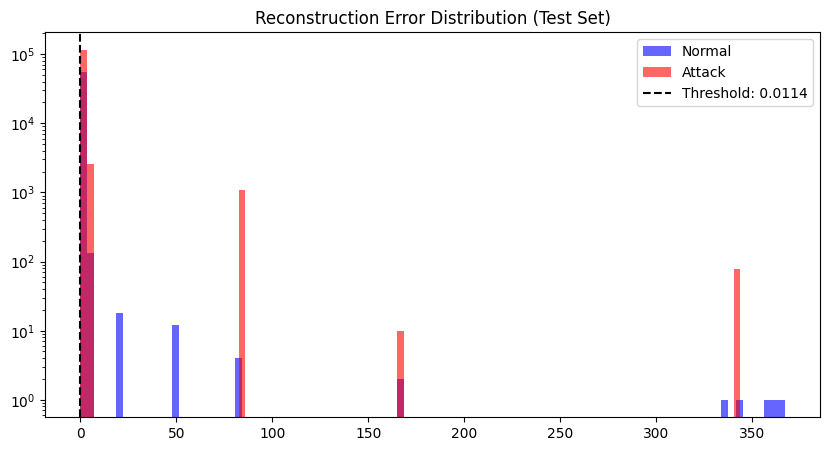

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(mse_per_sample[y_test==0], bins=100, color='blue', alpha=0.6, label='Normal', log=True)
plt.hist(mse_per_sample[y_test==1], bins=100, color='red', alpha=0.6, label='Attack', log=True)
plt.axvline(best_t, color='black', linestyle='--', label=f'Threshold: {best_t:.4f}')
plt.title("Reconstruction Error Distribution (Test Set)")
plt.legend()
plt.show()


In [43]:
y_pred = (mse_per_sample > best_t).astype(int)

              precision    recall  f1-score   support

           0       0.54      0.99      0.69     56000
           1       0.99      0.60      0.75    119341

    accuracy                           0.72    175341
   macro avg       0.76      0.79      0.72    175341
weighted avg       0.85      0.72      0.73    175341

ROC-AUC: 0.8345818484426979


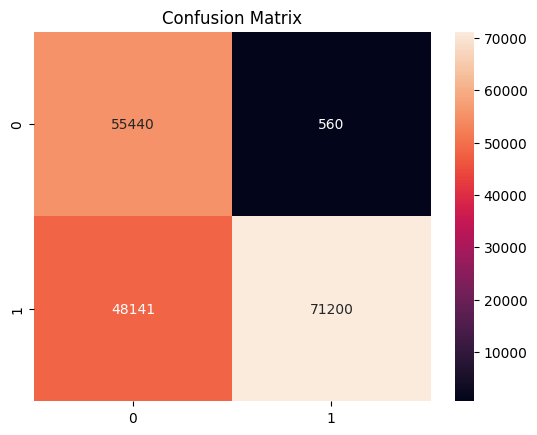

In [44]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, mse_per_sample))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.show()


### Testing from testing dataset

In [ ]:
testing_filepath = "/content/drive/MyDrive/FYP/Data/UNSW NB15/UNSW_NB15_testing-set.csv"
df_test = pd.read_csv(testing_filepath)
df_test.head()

In [ ]:
cleaned_df_test = clean_data(df_test)
cleaned_df_test.columns = cleaned_df_test.columns.str.strip()

print(cleaned_df_test.shape)

In [ ]:
df_test_processed = cleaned_df_test.drop(['id', 'attack_cat'], axis=1)

y_test_final = df_test_processed['label']
X_test_final = df_test_processed.drop(columns = ['label'])

print(f"Shape of X_test_final: {X_test_final.shape}")
print(f"Shape of y_test_final: {y_test_final.shape}")

In [ ]:
X_cat_test = encoder.transform(X_test_final[categorical_cols])
X_cat_test = pd.DataFrame(X_cat_test, columns=encoder.get_feature_names_out(categorical_cols), index=X_test_final.index)

X_num_test_filtered = X_test_final[relevant_features]

X_test_processed = pd.concat([X_num_test_filtered, X_cat_test], axis=1)
print(f"Shape of processed testing features: {X_test_processed.shape}")

In [ ]:
X_test_scaled_final = scaler.transform(X_test_processed)

print(f"Shape of scaled testing features: {X_test_scaled_final.shape}")

In [ ]:
reconstructions_final = autoencoder.predict(X_test_scaled_final)
mse_final = np.mean(np.square(X_test_scaled_final - reconstructions_final), axis=1)
print(f"Shape of reconstructions: {reconstructions_final.shape}")
print(f"Shape of MSE: {mse_final.shape}")

In [ ]:
y_pred_final = (mse_final > best_t).astype(int)
print(f"Shape of final predictions: {y_pred_final.shape}")

In [ ]:
print(classification_report(y_test_final, y_pred_final))
print("ROC-AUC:", roc_auc_score(y_test_final, mse_final))

sns.heatmap(confusion_matrix(y_test_final, y_pred_final), annot=True, fmt="d")
plt.title("Confusion Matrix - Testing Data")
plt.show()

### Save Model

In [ ]:
import os
MODEL_DIR = "detectionModel"
os.makedirs(MODEL_DIR, exist_ok=True)

In [ ]:
# save autoencoder
autoencoder.save(f"{MODEL_DIR}/autoencoder.keras")

# save scaler
import joblib
joblib.dump(scaler, f"{MODEL_DIR}/scaler.pkl")

# Save the encoder
joblib.dump(encoder, f"{MODEL_DIR}/encoder.pkl")

# save metadata
import json


metadata = {
    "numeric_columns": list(numeric_cols),
    "selected_numerical_columns": list(X_num_filtered.columns),
    "selected_categorical_columns: ": list(X_cat.columns),
    "categorical_columns": categorical_cols,
    "best_threshold": float(best_t)
}

with open(f"{MODEL_DIR}/metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

